In [1]:
from datetime import datetime
import warnings
import os
from collections import Counter

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import MinMaxScaler

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [3]:
(df, train_df, test_df, feature_names, next_two_weeks) = get_features_and_data()

training examples = 700, testing examples = 83


In [4]:
scale_features = ["days_since_previous_release", "days_until_next_holiday"]

In [5]:
scaler = MinMaxScaler().fit(train_df[scale_features])
train_df[scale_features] = scaler.transform(train_df[scale_features])
test_df[scale_features] = scaler.transform(test_df[scale_features])

In [6]:
scaler = MinMaxScaler().fit(df[scale_features])
df[scale_features] = scaler.transform(df[scale_features])
next_two_weeks[scale_features] = scaler.transform(next_two_weeks[scale_features])

## Model-Building and Evaluation

In [7]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", train_df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=train_df["prob_of_release"],
                       lower=0, upper=1, shape=features.shape[1])

In [8]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [9]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.55,0.13,1.31,1.80,0.00,0.00,2801.33,2589.09,1.0
release_prob,0.87,0.35,0.15,1.46,0.01,0.01,1993.05,2396.10,1.0
days_until_next_holiday,0.02,0.05,-0.07,0.11,0.00,0.00,4318.24,3035.76,1.0
WD_Thursday,0.02,0.05,-0.07,0.11,0.00,0.00,2171.06,2632.03,1.0
WD_Wednesday,-0.00,0.05,-0.09,0.09,0.00,0.00,2011.23,2196.07,1.0
previous_release_preorder,-0.04,0.07,-0.16,0.08,0.00,0.00,3269.05,2785.71,1.0
WD_Tuesday,-0.08,0.05,-0.16,0.01,0.00,0.00,1963.13,2077.89,1.0
WD_Monday,-0.15,0.04,-0.23,-0.07,0.00,0.00,1722.82,2043.84,1.0
previous_release,-0.18,0.06,-0.29,-0.07,0.00,0.00,1872.59,2535.23,1.0


In [10]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.32,0.05,0.22,0.42,0.0,0.0,1401.21,2040.28,1.0
error,0.23,0.01,0.20,0.25,0.0,0.0,2645.23,2801.25,1.0


### Out-of-Sample Evaluation

In [11]:
with model:
    pm.set_data({"features" : test_df[feature_names].T})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [12]:
y_pred = np.mean(pred_test.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [13]:
mape(test_df["prob_of_release"], y_pred)

0.21286762620206823

In [14]:
wape(test_df["prob_of_release"], y_pred)

np.float64(0.19057162682749854)

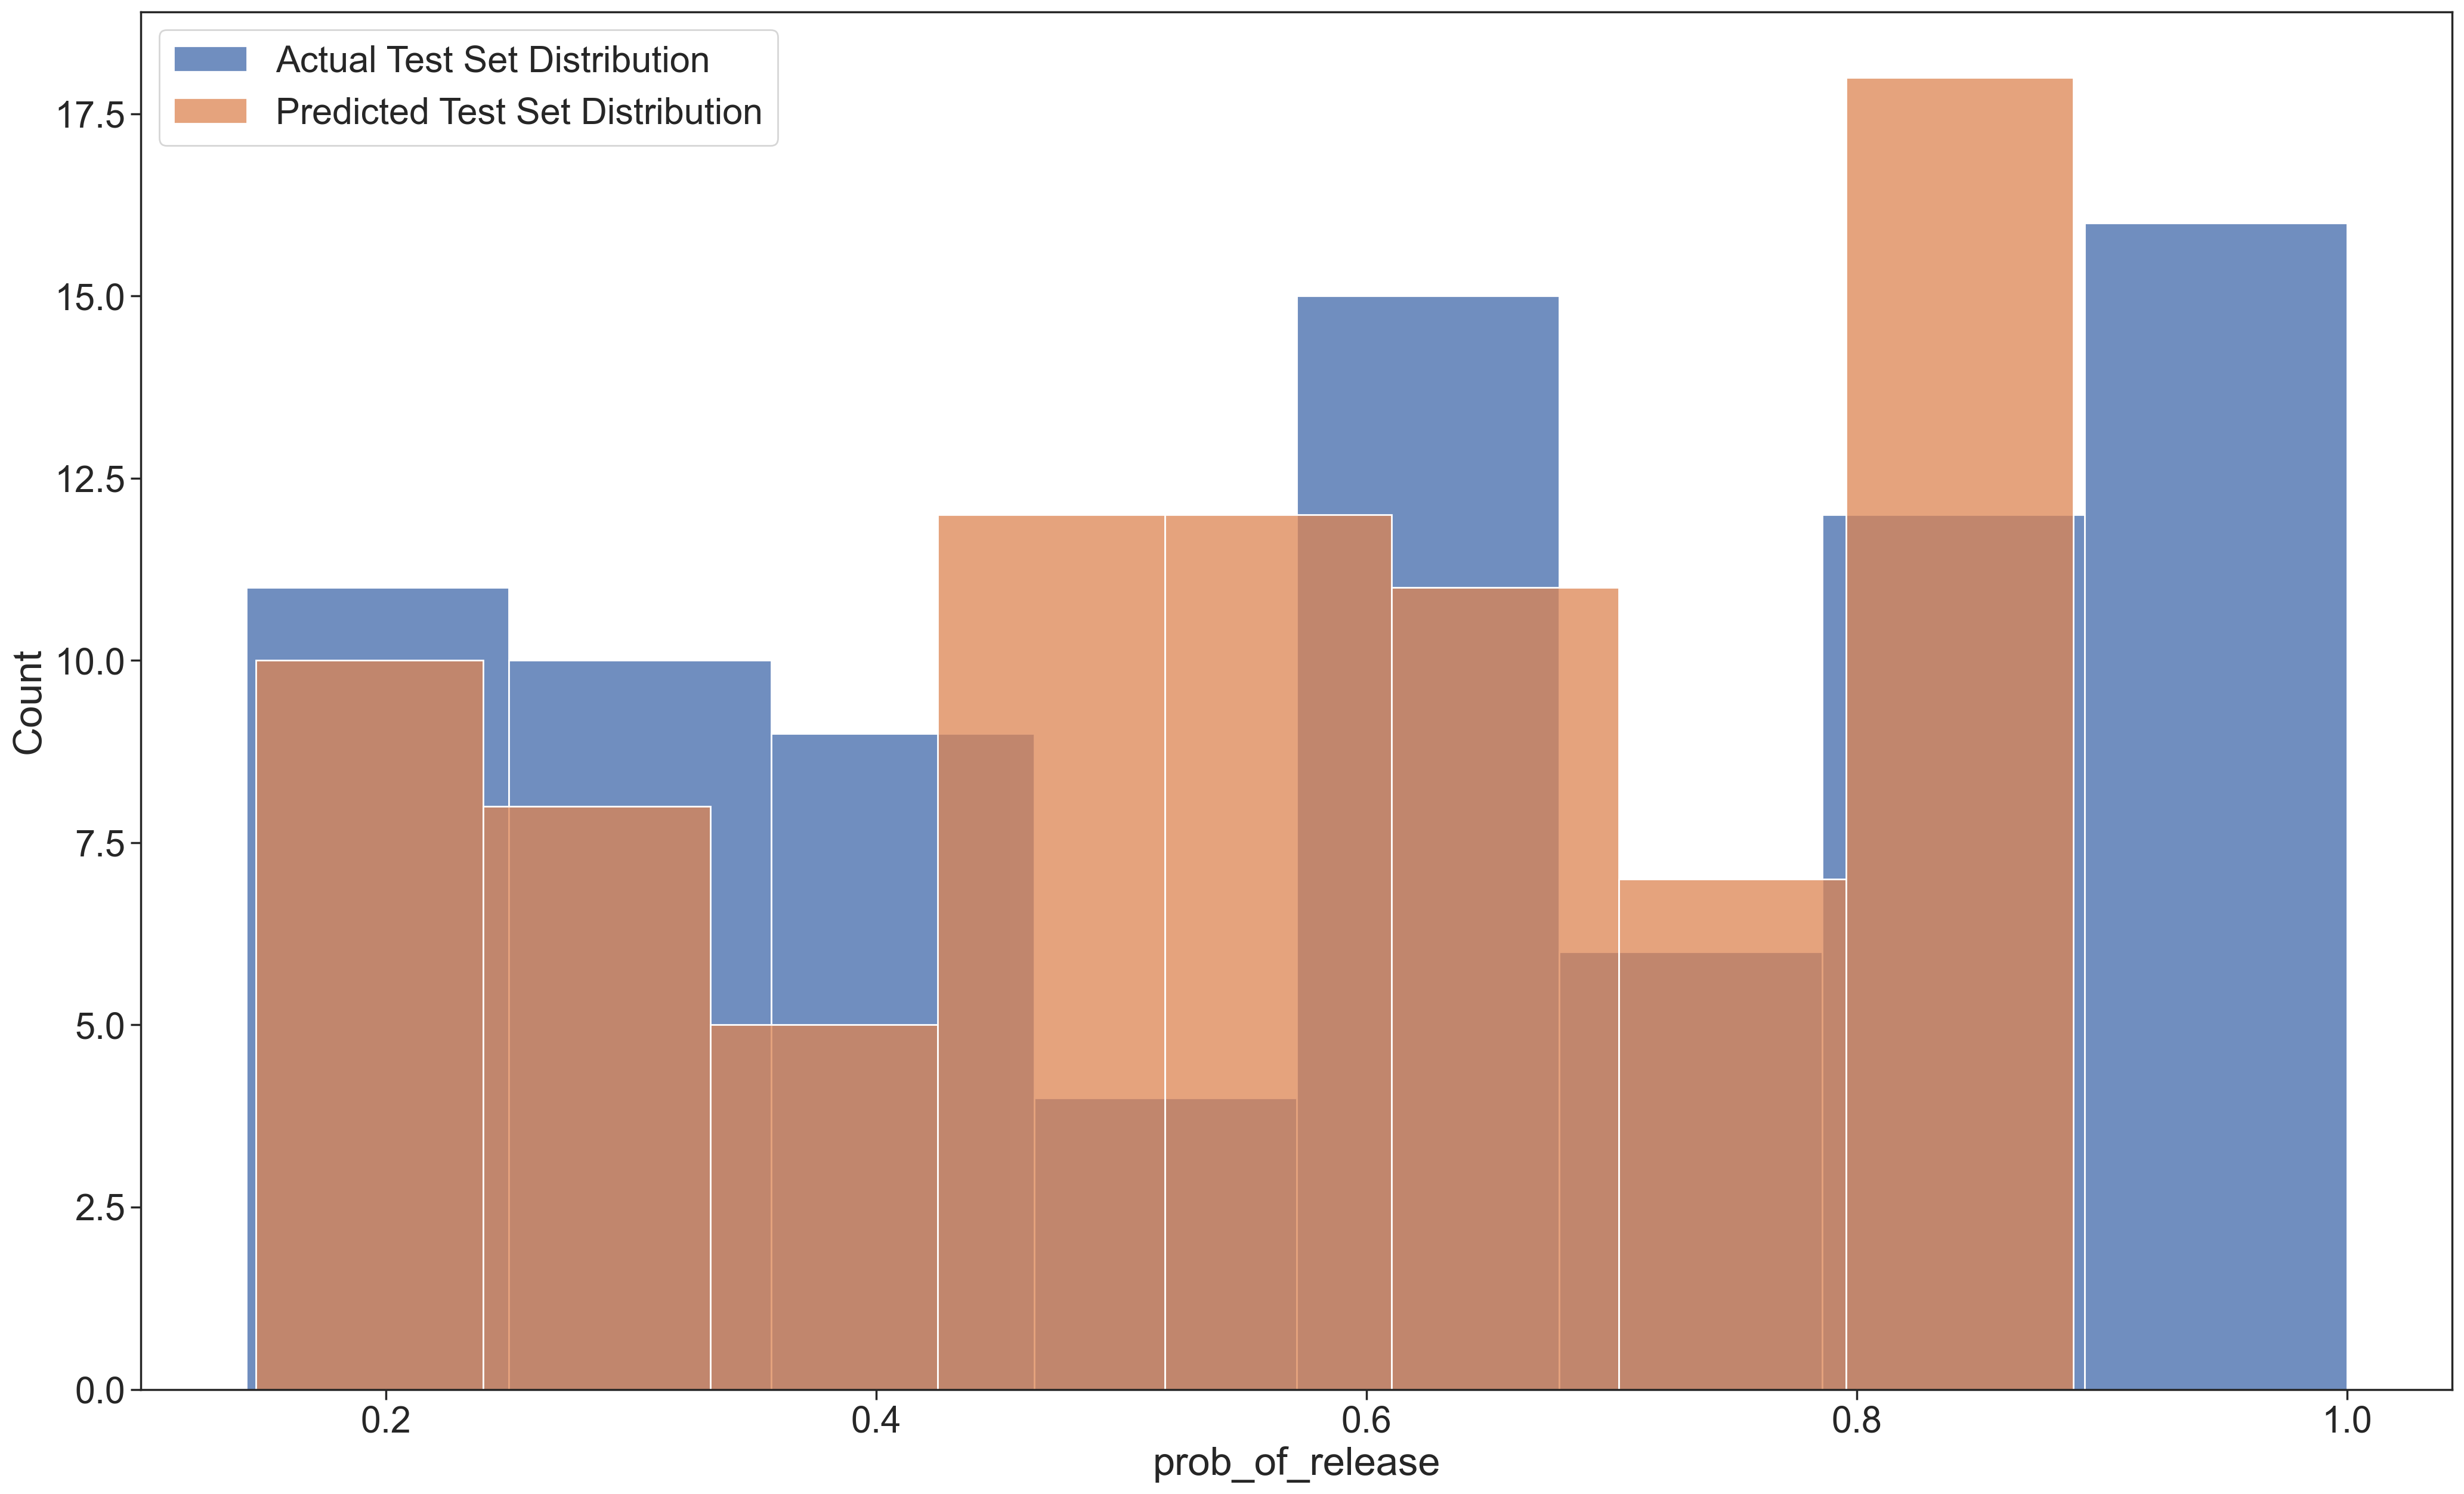

In [15]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=y_pred, ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

## Predictions for the Next Two Weeks

In [16]:
with pm.Model() as model:
    # data
    features = pm.MutableData("features", df[feature_names].T)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    error = pm.HalfNormal("error", sigma=0.5)
    # linear model
    mu = beta0 + pm.math.dot(weights, features)
    # likelihood
    pm.TruncatedNormal("y_pred", mu=mu, sigma=error, observed=df["prob_of_release"], lower=0, upper=1, shape=features.shape[1])

In [17]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0, error]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [18]:
weights_df = az.summary(idata, round_to=2, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
days_since_previous_release,1.55,0.12,1.31,1.77,0.0,0.0,2565.79,2478.96,1.0
release_prob,0.89,0.24,0.44,1.35,0.0,0.0,3156.19,3139.96,1.0
WD_Thursday,0.02,0.04,-0.05,0.10,0.0,0.0,2345.77,2693.61,1.0
days_until_next_holiday,-0.00,0.05,-0.08,0.09,0.0,0.0,4487.24,2420.24,1.0
WD_Wednesday,-0.02,0.04,-0.09,0.06,0.0,0.0,2210.38,2406.19,1.0
previous_release_preorder,-0.04,0.06,-0.16,0.07,0.0,0.0,4281.59,2917.73,1.0
WD_Tuesday,-0.07,0.04,-0.15,0.00,0.0,0.0,2116.04,2307.94,1.0
WD_Monday,-0.15,0.04,-0.22,-0.07,0.0,0.0,1885.94,2512.75,1.0
previous_release,-0.17,0.05,-0.26,-0.07,0.0,0.0,2535.36,2903.81,1.0


In [19]:
az.summary(idata, round_to=2, var_names=["beta0", "error"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.33,0.04,0.26,0.42,0.0,0.0,1771.58,2310.1,1.0
error,0.22,0.01,0.20,0.24,0.0,0.0,2677.09,2421.3,1.0


In [20]:
with model:
    pm.set_data({"features" : next_two_weeks[feature_names].T})
    pred_next = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_pred"])

Sampling: [y_pred]


Output()

In [21]:
next_two_weeks["predicted_prob"] = np.mean(pred_next.predictions["y_pred"].stack(all_draws=["chain", "draw"]).values, axis=1)

In [22]:
hdi = pm.hdi(pred_next.predictions["y_pred"], hdi_prob=0.95)
next_two_weeks["predicted_min"] = hdi["y_pred"][:, 0]
next_two_weeks["predicted_max"] = hdi["y_pred"][:, 1]

In [23]:
next_two_weeks[["index", "predicted_min", "predicted_prob", "predicted_max"]].round(4)

,index,predicted_min,predicted_prob,predicted_max
0,2025-02-28,0.6540,0.8732,0.9999
1,2025-03-01,0.5080,0.7879,0.9998
2,2025-03-02,0.5783,0.8335,1.0000
3,2025-03-03,0.6817,0.8836,0.9999
4,2025-03-04,0.7604,0.9135,1.0000
5,2025-03-05,0.7933,0.9311,1.0000
6,2025-03-06,0.8348,0.9431,1.0000
7,2025-03-07,0.8457,0.9485,1.0000
8,2025-03-08,0.8350,0.9448,1.0000
9,2025-03-09,0.8505,0.9495,1.0000


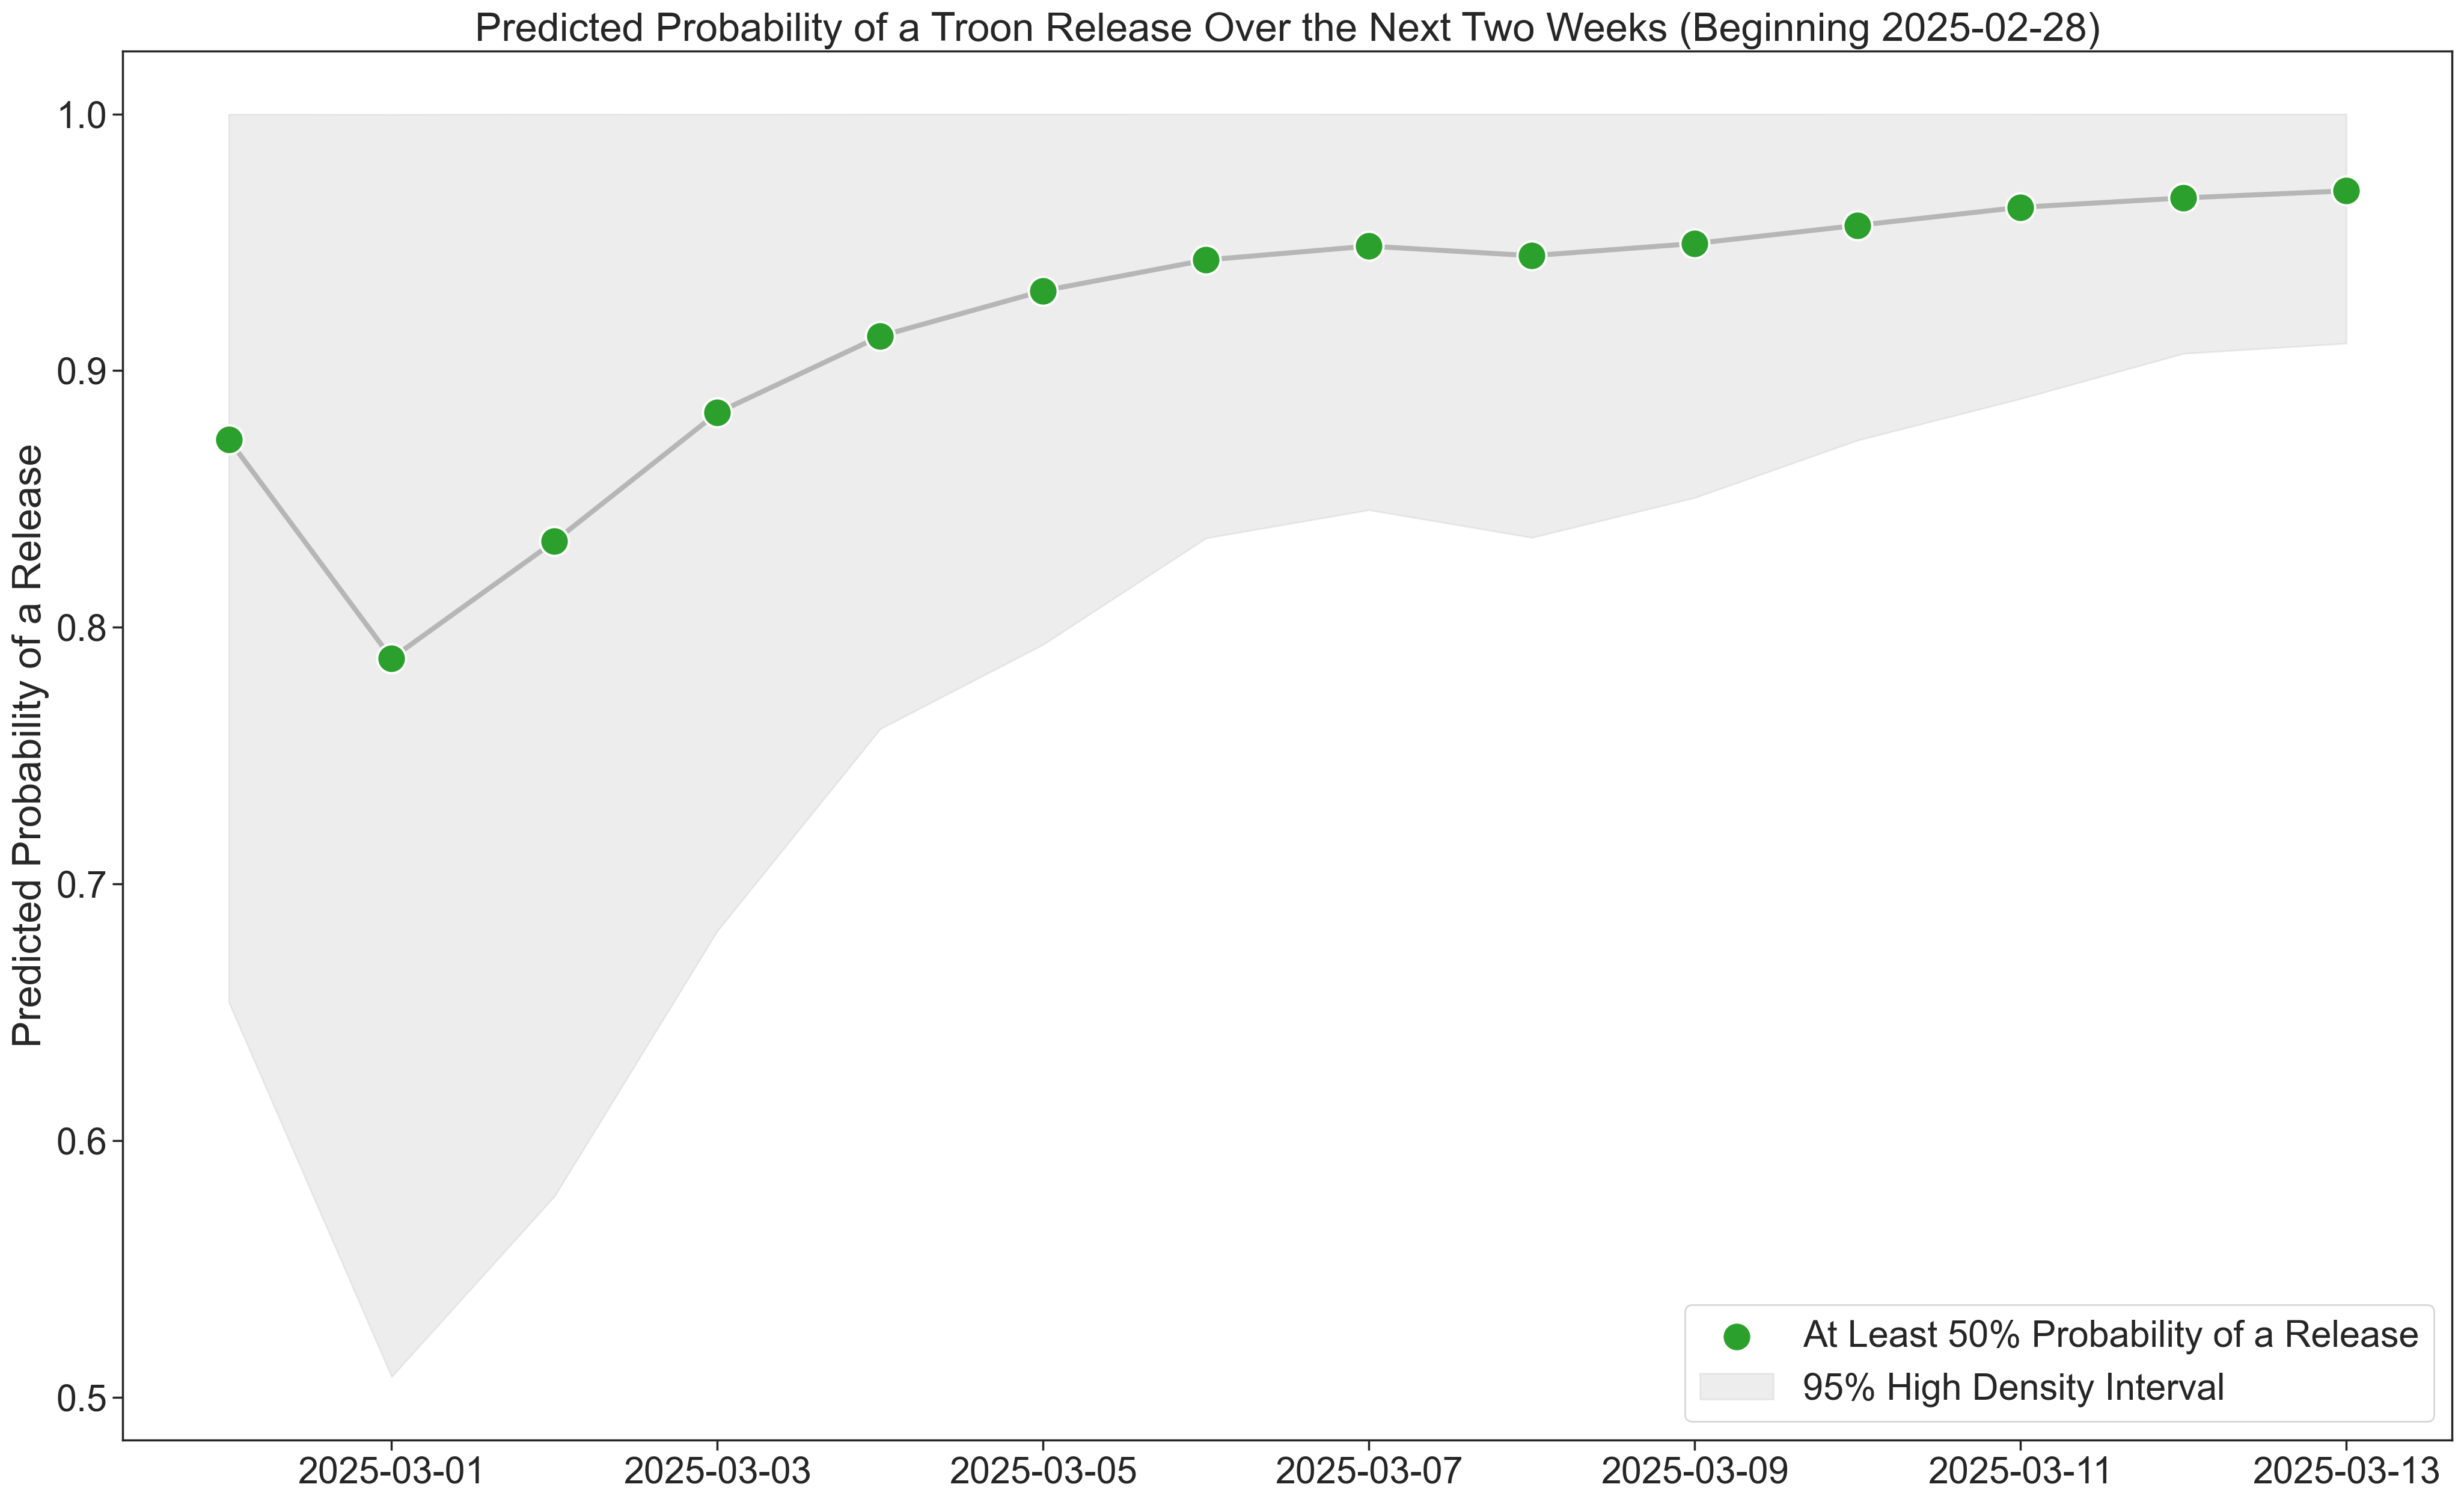

In [24]:
ax = sns.lineplot(data=next_two_weeks, x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_two_weeks[next_two_weeks["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release", zorder=2)

ax.fill_between(x=next_two_weeks["index"],
                y1=next_two_weeks["predicted_min"],
                y2=next_two_weeks["predicted_max"],
                label="95% High Density Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_two_weeks["index"].iloc[0].date()))
ax.legend()
plt.show()